MIT License

Copyright (c) 2024 jo,gu,hc,ha

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [ ]:
!pip install mord

In [ ]:
pip install dmba

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
import sys
import sklearn
version = ".".join(map(str, sys.version_info[:3]))
print('Python version:', version)
print('Sklearn version:', sklearn.__version__)

Python version: 3.10.12
Sklearn version: 1.5.2


##EDA Analysis##

In [ ]:
titanic = pd.read_csv('train.csv')

In [ ]:
missing_values = titanic.isnull().sum()
missing_values

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


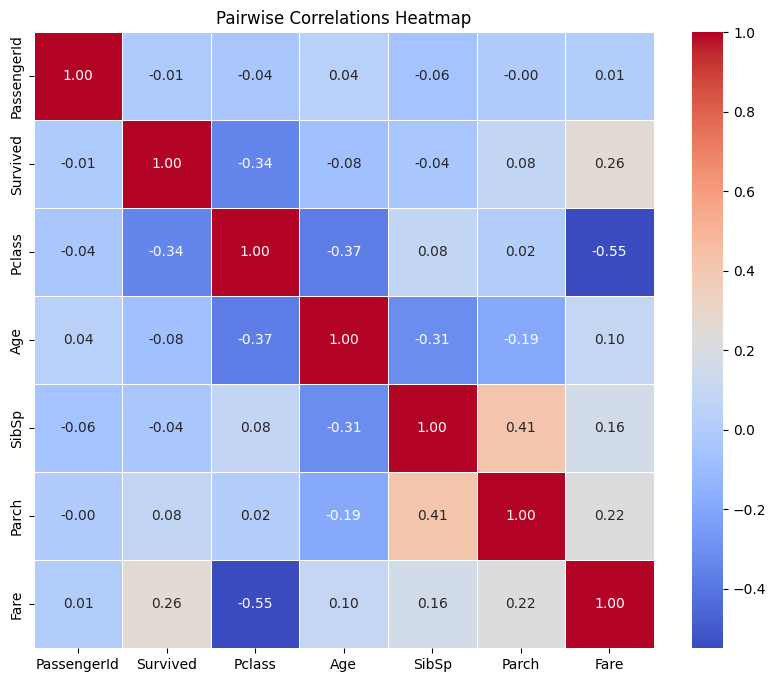

In [ ]:
numeric_cols = titanic.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = titanic[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pairwise Correlations Heatmap')
plt.show()

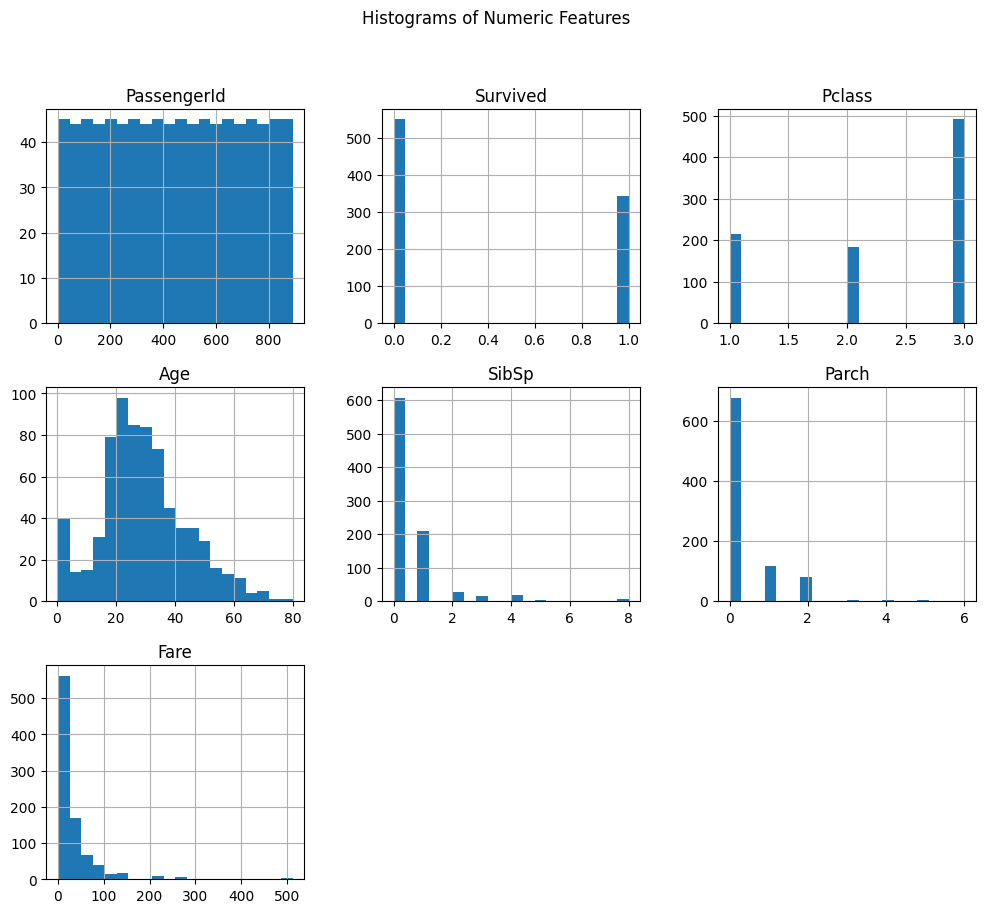

In [ ]:
# Histograms for numeric features
titanic[numeric_cols].hist(bins=20, figsize=(12, 10), layout=(3, 3))
plt.suptitle('Histograms of Numeric Features')
plt.show()


Survival Rate by Pclass:
 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Survival Rate by Sex:
 Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Survival Rate by Embarked:
 Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


<ipython-input-95-122c7694cf34>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='Survived', data=titanic, ci=None)


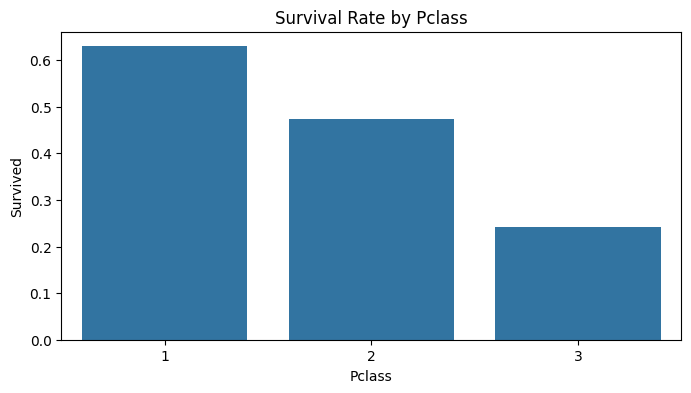

<ipython-input-95-122c7694cf34>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='Survived', data=titanic, ci=None)


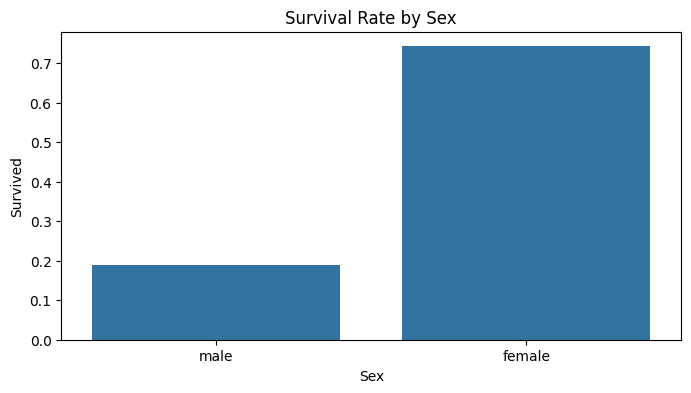

<ipython-input-95-122c7694cf34>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y='Survived', data=titanic, ci=None)


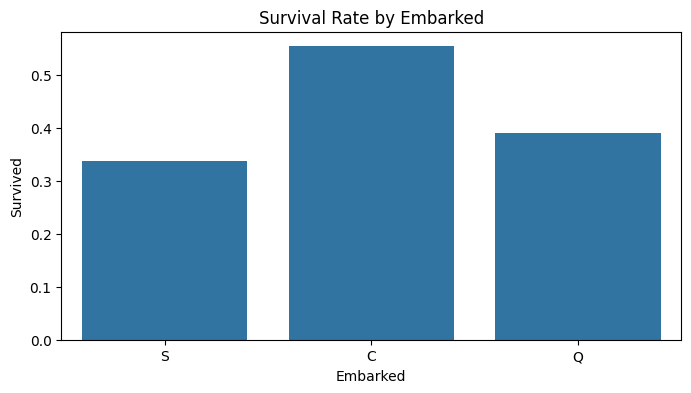

In [ ]:
# Calculate survival rates by feature
for col in ['Pclass', 'Sex', 'Embarked']:
    survival_rate = titanic.groupby(col)['Survived'].mean()
    print(f"\nSurvival Rate by {col}:\n", survival_rate)

# Visualize survival rates
for col in ['Pclass', 'Sex', 'Embarked']:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=col, y='Survived', data=titanic, ci=None)
    plt.title(f'Survival Rate by {col}')
    plt.show()

<ipython-input-96-040fcc47a56f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_survival_summary = titanic.groupby(['AgeGroup', 'Survived']).size().unstack()


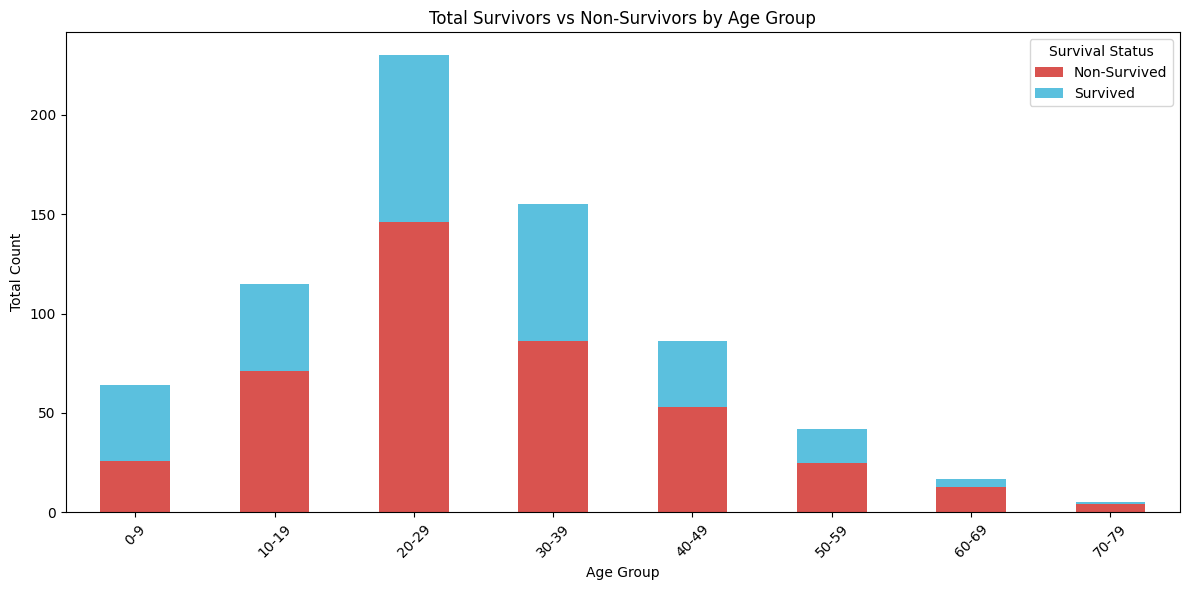

In [ ]:
titanic['AgeGroup'] = pd.cut(titanic['Age'], bins=np.arange(0, 81, 10), labels=[f'{i}-{i+9}' for i in range(0, 80, 10)])

# Group by AgeGroup and Survival status
age_survival_summary = titanic.groupby(['AgeGroup', 'Survived']).size().unstack()

# Plot total survivors vs non-survivors by age group
age_survival_summary.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#D9534F', '#5BC0DE'])
plt.title('Total Survivors vs Non-Survivors by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Count')
plt.legend(['Non-Survived', 'Survived'], title='Survival Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-97-ebdf450fc7c9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=titanic, x='Survived', y='Fare', palette='Set3')


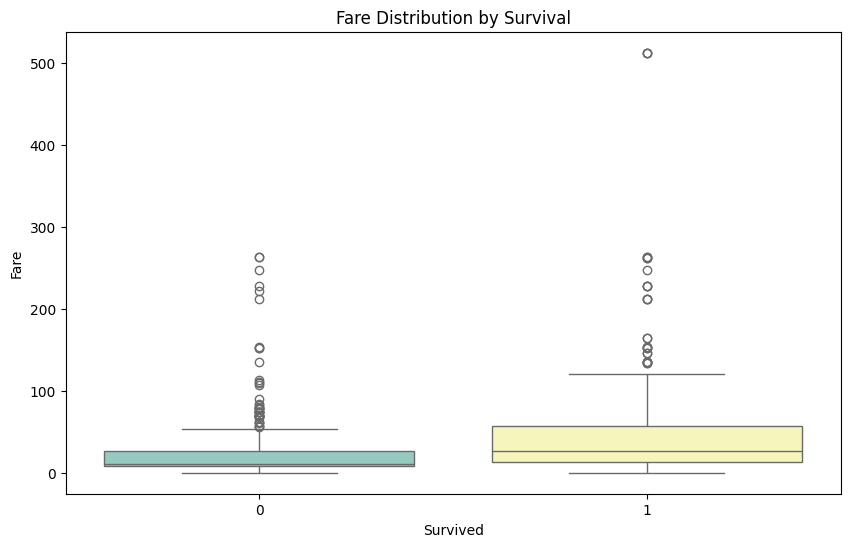

In [ ]:
# Fare distribution by survival
plt.figure(figsize=(10, 6))
sns.boxplot(data=titanic, x='Survived', y='Fare', palette='Set3')
plt.title('Fare Distribution by Survival')
plt.show()

##Training Data##

In [ ]:
titanic = pd.read_csv('train.csv')
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


##Test Data##

In [ ]:
titanic_test = pd.read_csv('test.csv')
titanic_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


##Model Details##

In [ ]:
def check_data_type(value):
    if isinstance(value, int):
        return 'int'
    elif isinstance(value, float):
        return 'float'
    elif isinstance(value, str):
        return 'string'
    elif isinstance(value, bool):
        return 'bool'
    elif pd.isnull(value):
        return 'NoneType'
    else:
        return 'object'

data_types = titanic.applymap(check_data_type)

print(data_types)

    PassengerId Survived Pclass    Name     Sex    Age SibSp Parch  Ticket  \
0           int      int    int  string  string  float   int   int  string   
1           int      int    int  string  string  float   int   int  string   
2           int      int    int  string  string  float   int   int  string   
3           int      int    int  string  string  float   int   int  string   
4           int      int    int  string  string  float   int   int  string   
..          ...      ...    ...     ...     ...    ...   ...   ...     ...   
886         int      int    int  string  string  float   int   int  string   
887         int      int    int  string  string  float   int   int  string   
888         int      int    int  string  string  float   int   int  string   
889         int      int    int  string  string  float   int   int  string   
890         int      int    int  string  string  float   int   int  string   

      Fare   Cabin Embarked  
0    float   float   string  
1  

<ipython-input-100-df9c42def6f3>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_types = titanic.applymap(check_data_type)


##Model##

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Dropping columns that won't be useful for the prediction
titanic.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

# adding siblings, children, and parents as one variable 'FamilySize' and adding a new column identifying if the traveler was travelling alone
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic['IsAlone'] = (titanic['FamilySize'] == 1).astype(int)
titanic.drop(columns=['SibSp', 'Parch'], inplace=True)

# Filling missing values in the training set
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace=True)

# Converting categorical variables to numerical ones
titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})
titanic = pd.get_dummies(titanic, columns=['Embarked'], drop_first=True)

<ipython-input-101-1be905973334>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
<ipython-input-101-1be905973334>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [ ]:
# model details
print(sklearn.__version__)

print("Columns used as inputs:")
for column in titanic.columns:
    print(column)

1.5.2
Columns used as inputs:
PassengerId
Survived
Pclass
Sex
Age
Fare
FamilySize
IsAlone
Embarked_Q
Embarked_S


In [ ]:
# Defining features (X) and target (y)
X = titanic.drop('Survived', axis=1)
y = titanic['Survived']

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions on the validation set
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Calculating accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Training Set Accuracy:", train_accuracy)
print("Validation Set Accuracy:", val_accuracy)


Training Set Accuracy: 1.0
Validation Set Accuracy: 0.8435754189944135


In [ ]:
# test_passenger_id = titanic_test['PassengerId']

# Dropping columns that won't be useful for the prediction
titanic_test.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

# adding siblings and children as one variable 'FamilySize' and adding a new column identifying if the traveler was travelling alone
titanic_test['FamilySize'] = titanic_test['SibSp'] + titanic_test['Parch'] + 1
titanic_test['IsAlone'] = (titanic_test['FamilySize'] == 1).astype(int)
titanic_test.drop(columns=['SibSp', 'Parch'], inplace=True)

# Filling missing values in the training set
titanic_test['Age'].fillna(titanic_test['Age'].median(), inplace=True)
titanic_test['Embarked'].fillna(titanic_test['Embarked'].mode()[0], inplace=True)

# Converting categorical variables to numerical ones
titanic_test['Sex'] = titanic_test['Sex'].map({'male': 0, 'female': 1})
titanic_test = pd.get_dummies(titanic_test, columns=['Embarked'], drop_first=True)

# Ensure the test data has the same columns as the training data
missing_cols = set(X.columns) - set(titanic_test.columns)
for col in missing_cols:
    titanic_test[col] = 0
titanic_test = titanic_test[X.columns]

# Making predictions on the test set
y_test_pred = rf_model.predict(titanic_test)

# Creating the submission DataFrame
submission = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_test_pred})

# Preview the submission DataFrame
print(submission.head())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


<ipython-input-103-5aa8b3bcebcf>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_test['Age'].fillna(titanic_test['Age'].median(), inplace=True)
<ipython-input-103-5aa8b3bcebcf>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [ ]:
# Save the submission file
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0



```
# This is formatted as code
```

##Quantitative Analysis##

Model Evaluation Metrics:
  Metric  Training Data  Validation Data
0    AUC            1.0         0.904247
1    AIR            1.0         0.832754


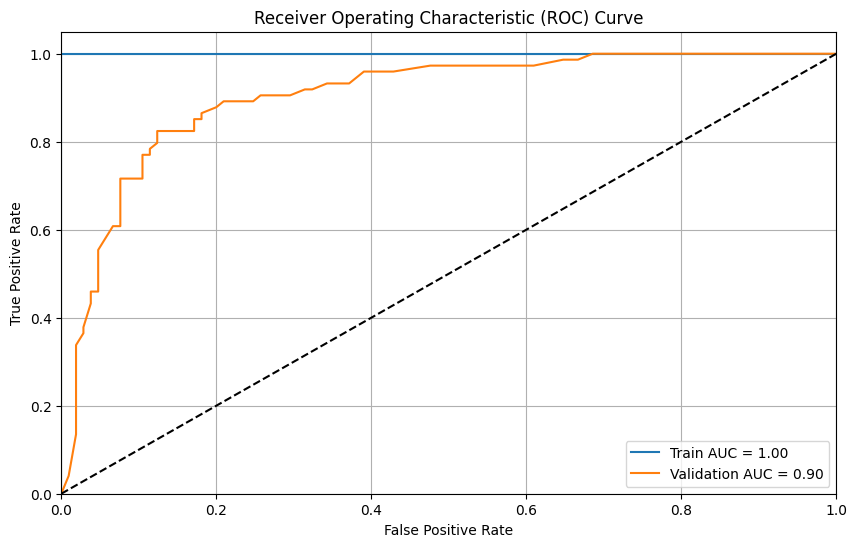

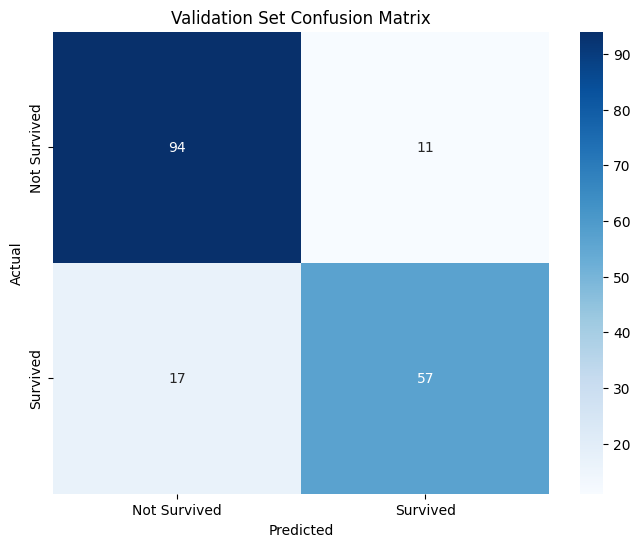

Validation Set Metrics:
Accuracy: 0.84
Precision: 0.84
Recall (True Positive Rate, TPR): 0.77
F1 Score: 0.80


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Predictions for training and validation sets
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Get probabilities for AUC calculation
y_train_proba = rf_model.predict_proba(X_train)[:, 1]
y_val_proba = rf_model.predict_proba(X_val)[:, 1]

# Calculate AUC
train_auc = roc_auc_score(y_train, y_train_proba)
val_auc = roc_auc_score(y_val, y_val_proba)

# Confusion matrix for training and validation sets
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Calculate AIR (Average Information Ratio)
def calculate_air(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return (sensitivity + specificity) / 2

train_air = calculate_air(train_conf_matrix)
val_air = calculate_air(val_conf_matrix)

# Display metrics
metrics = {
    "Metric": ["AUC", "AIR"],
    "Training Data": [train_auc, train_air],
    "Validation Data": [val_auc, val_air]
}

metrics_df = pd.DataFrame(metrics)
print("Model Evaluation Metrics:")
print(metrics_df)

# ROC curve data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(train_auc))
plt.plot(fpr_val, tpr_val, label='Validation AUC = {:.2f}'.format(val_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Confusion Matrix for Validation Set
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate metrics for the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Print metrics
print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (True Positive Rate, TPR): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

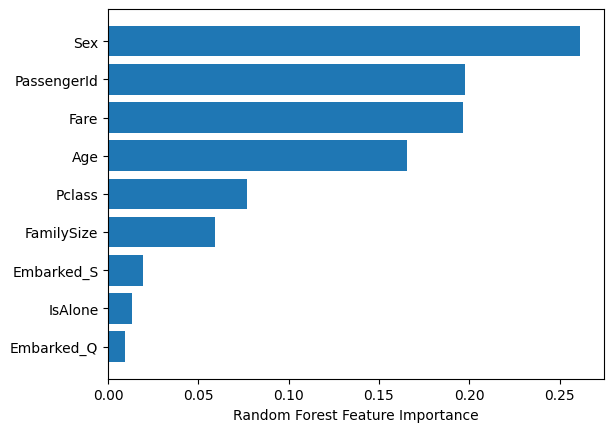

In [ ]:
import matplotlib.pyplot as plt
feature_importances = rf_model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

##Ethical Considerations##